# A Style Neural Network with long range consistency


In [2]:
% matplotlib inline

import numpy as np 

import matplotlib.pyplot as plt

import scipy
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics

from VGG16 import VGG16

from keras.models import Model

from keras import backend as K

from PIL import Image


Using TensorFlow backend.


First, defining the VGG network 

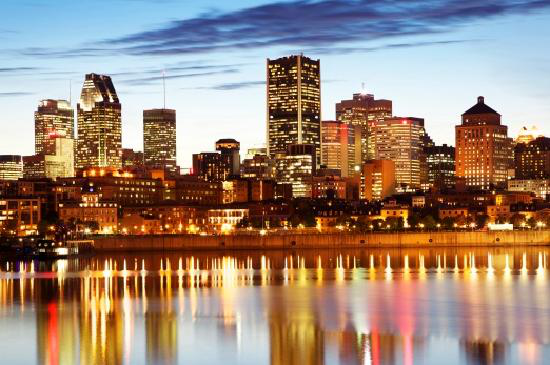

In [3]:
content = Image.open('images/inputs/content/downtown-montreal.jpg')
content

I want to mantain the size of my original size, so I need to make sure to resize my input style image appropriately. 

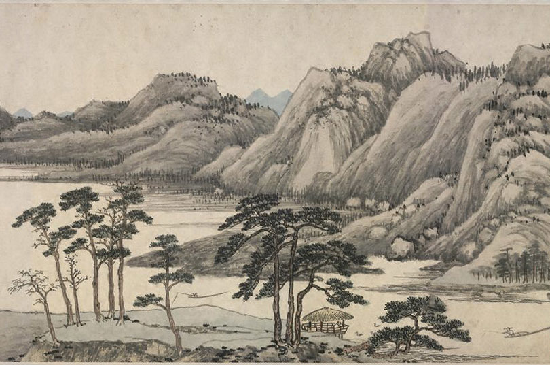

In [4]:
style = Image.open('images/inputs/style/fuchun-mountains.jpg').resize(content.size)
style

## Preprocessing the images

In [5]:
def image_preprocess(img_ar):
    '''
    Input: image as numpy array
    Output: preprocessed image as numpy array
    '''
    resnet_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
    exp_img_ar = np.expand_dims(np.array(img_ar), 0)
    proc_img_ar = (exp_img_ar - resnet_mean)[:,:,:,::-1]
    return proc_img_ar
#end

def image_postprocess(img_ar, shp):
    '''Input: preprocessed image as numpy array
       Output: postprocessed image as numpy array
    '''
    resnet_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
    postpr_img_ar = np.clip(img_ar.reshape(shp)[:,:,:,::-1] + resnet_mean, 0, 255)
    return postpr_img_ar
#end

In [6]:
content_array = image_preprocess(content)

In [7]:
style_array = image_preprocess(style)

In [23]:
image_array_shape = content_array.shape

## Defining the losses

### Content Loss

In [22]:
def content_loss(computed, target, weight_ls=None):
    '''
    Input: computed and target tensors (or lists of tensors for more than one content layer)
    Output: content loss calculated as MSE and scaled by the tensor(s) dimension
    '''
    if isinstance(computed, list):
        if not weight_ls:
            weight_ls = [1.0 for layer in computed]
        #end
        c_loss = sum([K.sum(metrics.mse(comp[0], targ[0]) * w \
                      for comp, targ, w in zip(computed, target, weight_ls))])
        _, height, width, channels = map(lambda i: i, K.int_shape(computed[0]))
    else:
        c_loss = K.sum(metrics.mse(computed, target))
        _, height, width, channels = K.int_shape(computed)
    #end
    c_loss = c_loss #/ (height * width * channels)
    return c_loss

### Style losses

#### Classic style loss

In [20]:
def gram_matrix(tens):
    features = K.batch_flatten(K.permute_dimensions(tens, (2, 0, 1))) # rows = channels, columns = flattened x, y
    gram = K.dot(features, K.transpose(features)) / tens.get_shape().num_elements() #correlate each pair of channels
    return gram
#end

def style_loss(computed, target, weight_ls=None):
    '''
    Input: computed and target tensors (or lists of tensors for more than one style layer)
    Output: content loss calculated as MSE of the Gram matrices and scaled by the tensor(s) dimension
    '''
    if isinstance(computed, list):
        if not weight_ls:
            weight_ls = [1.0 for layer in computed]
        #end
        s_loss = sum([K.sum(metrics.mse(gram_matrix(comp[0]), gram_matrix(targ[0]))) * w \
                      for comp, targ, w in zip(computed, target, weight_ls)])
        _, height, width, channels = map(lambda i: i, K.int_shape(computed[0]))
    else:
        s_loss = K.sum(metrics.mse(gram_matrix(computed), gram_matrix(target)))
        _, height, width, channels = K.int_shape(computed)
    #end
    s_loss = s_loss #/ (height * width * channels)
    return s_loss

#### Spatial Co Occurences Loss

In [9]:
def gram_xcc(x, pixel_shift = 4):
    # First, we want to only take part of the x locations
    
    x_positive_shift = K.tf.gather(x, K.tf.range(0, x.shape[0]-pixel_shift))
    x_negative_shift = K.tf.gather(x, K.tf.range(pixel_shift, x.shape[0]))
    
    # We want each row to be a channel, and the columns to be flattened x,y locations
    features_positive_shift = K.batch_flatten(K.permute_dimensions(x_positive_shift, (2, 0, 1)))
    features_negative_shift = K.batch_flatten(K.permute_dimensions(x_negative_shift, (2, 0, 1)))
    
    # Now, I want to 'shift' the features tensor, by deleting pixels from opposite sides
    
    # The dot product of this with its transpose shows the correlation 
    # between each pair of channels
    return K.dot(features_positive_shift, K.transpose(features_negative_shift)) / x_positive_shift.get_shape().num_elements()

In [10]:
def gram_ycc(x, pixel_shift = 4):
    x_positive_shift = x[:, pixel_shift:, :]
    x_negative_shift = x[:, :x.shape[1] - pixel_shift, :]
    # We want each row to be a channel, and the columns to be flattened x,y locations
    features_positive_shift = K.batch_flatten(K.permute_dimensions(x_positive_shift, (2, 0, 1)))
    features_negative_shift = K.batch_flatten(K.permute_dimensions(x_negative_shift, (2, 0, 1)))
    
    # Now, I want to 'shift' the features tensor, by deleting pixels from opposite sides
    
    # The dot product of this with its transpose shows the correlation 
    # between each pair of channels
    return K.dot(features_positive_shift, K.transpose(features_negative_shift)) / x_positive_shift.get_shape().num_elements()

In [11]:
def cc_loss(computed, target):
    if isinstance(computed, list):
        x_loss = sum([K.sum(metrics.mse(gram_xcc(comp[0]), gram_xcc(targ[0]))) 
                      for comp, targ in zip(computed, target)])
        y_loss = sum([K.sum(metrics.mse(gram_ycc(comp[0]), gram_ycc(targ[0]))) 
                      for comp, targ in zip(computed, target)])
        s_loss = K.tf.multiply(0.5, K.tf.add(x_loss, y_loss))
    else:
        x_loss = K.sum(metrics.mse(gram_xcc(computed), gram_xcc(target)))
        y_loss = K.sum(metrics.mse(gram_ycc(computed), gram_ycc(target)))
        s_loss = K.tf.multiply(0.5, K.tf.add(x_loss, y_loss))
        #_, height, width, channels = K.int_shape(computed)
    return s_loss

In [12]:
def total_loss(style_layer_ls, style_targ_ls, style_wgt_ls, content_layer, content_targ, style2content_ratio):
    s_loss = style_loss(style_layer_ls, style_targ_ls, style_wgt_ls) + cc_loss(style_layer_ls, style_targ_ls)
    c_loss = content_loss(content_layer, content_targ)
    loss = s_loss + c_loss / style2content_ratio
    return loss
#end

## Getting the targets

In [13]:
def get_content_targets(style_transfer_model, content_ar):
    '''
    Input: style transfer model and numpy array of the content image
    Output: the output of the model at the content layer and its respective target
    '''
    layer_output_dc = {l.name: l.get_output_at(0) for l in style_transfer_model.layers}
    content_layer = layer_output_dc['block4_conv2'] #change it to another layer of choice if necessary
    content_model = Model(style_transfer_model.input, content_layer)
    content_targ = K.variable(content_model.predict(content_ar))
    return content_layer, content_targ
#end 

In [14]:
def get_style_targets(style_transfer_model, style_ar):
    '''Input: style transfer model and numpy array of the style image
       Output: the output of the model at the style layer(s) and its respective target
    '''
    layer_output_dc = {l.name: l.get_output_at(0) for l in style_transfer_model.layers}
    style_layer_ls = [layer_output_dc['block{}_conv2'.format(o)] for o in range(1,6)] #change it different layers if necessary
    style_model = Model(style_transfer_model.input, style_layer_ls)
    style_targ_ls = [K.variable(o) for o in style_model.predict(style_ar)]
    return style_layer_ls, style_targ_ls
#end 

Defining the evaluator

In [15]:
class Evaluator(object):
    '''
    Initialization: function and shape of the image array
    Returns the loss and the gradients as computed with
       respect to the image that is fed to the CNN
    '''
    def __init__(self, f, shp):
        self.f = f
        self.shp = shp
        return
    #end        
    def loss(self, x):
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)
    #end
    def grads(self, x): 
        return self.grad_values.flatten().astype(np.float64)
    #end    
#end

In [16]:
def apply_transfer(eval_obj, n_iter, img, shp, path='./', pref='', save=True, verbose=True):
    '''
    Input: evaluator, number of iterations, input image and shape
    Output: final image, list of losses and info dictionary of optimization procedure
    '''
    info_dc = dict()
    loss_ls = list()
    for it in range(n_iter):
        img, min_val, iter_dc = fmin_l_bfgs_b(eval_obj.loss, img.flatten(),
                                              fprime=eval_obj.grads, maxfun=20, iprint = 1)
        img = np.clip(img, -127, 127)
        info_dc['iteration_'+str(it+1)] = iter_dc
        loss_ls = loss_ls + [min_val]
        if verbose:
            print('Current loss value:', min_val)
        #end
        if save:
            imsave(path + pref + 'res_at_iteration_' + str(it+1) + '.png', image_postprocess(img.copy(), shp)[0])
        #end
    #end
    return img, loss_ls, info_dc
#end

In [17]:
transfer_model = VGG16(pooling = 'Average', include_top =False, input_shape = image_array_shape[1:])

In [18]:
content_layer, content_targ = get_content_targets(transfer_model, content_array)
style_layer_ls, style_targ_ls = get_style_targets(transfer_model, style_array)

In [24]:
iterations = 10

content_layer, content_targ = get_content_targets(transfer_model, content_array)
style_layer_ls, style_targ_ls = get_style_targets(transfer_model, style_array)

style_wgt_ls = [0.05,0.2,0.2,0.25,0.3]
style2content_ratio = 5.0
loss = total_loss(style_layer_ls, style_targ_ls, style_wgt_ls, content_layer, content_targ, style2content_ratio)
grads = K.gradients(loss, transfer_model.input)
transfer_fn = K.function([transfer_model.input], [loss] + grads)
evaluator = Evaluator(transfer_fn, image_array_shape)

Starting from a random image

In [25]:
virgin_img = np.random.uniform(-2.5, 2.5, image_array_shape)/100

image, t_loss, info_dc = apply_transfer(evaluator, iterations, virgin_img, image_array_shape, path='images/co_occurence_test/random_start/')

Current loss value: 4725928.0
Current loss value: 2598138.5
Current loss value: 1942405.0
Current loss value: 1611926.25
Current loss value: 1445422.75
Current loss value: 1358920.125
Current loss value: 1306763.75
Current loss value: 1270754.125
Current loss value: 1243049.75
Current loss value: 1220167.0


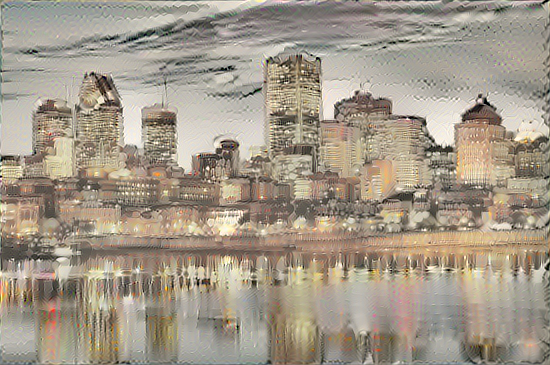

In [26]:
Image.open('images/co_occurence_test/random_start/res_at_iteration_10.png')

## Starting with the content image (as per Novak and Nikulin) 

In [27]:
iterations = 10

start_img = np.copy(content_array)

image, t_loss, info_dc = apply_transfer(evaluator, iterations, start_img, image_array_shape, path='images/co_occurence_test/content_start/')

Current loss value: 1536934.25
Current loss value: 1267710.25
Current loss value: 1169193.0
Current loss value: 1122785.375
Current loss value: 1095380.75
Current loss value: 1077058.125
Current loss value: 1064179.0
Current loss value: 1054775.625
Current loss value: 1047188.375
Current loss value: 1041219.5625


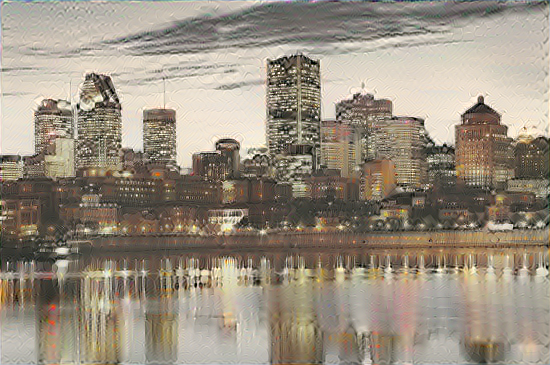

In [28]:
Image.open('images/co_occurence_test/content_start/res_at_iteration_10.png')